# NB02: GapMind Gaps, Cross-Organism Concordance & Phylogenetic Distribution

**Goal**: Apply three new inference layers not covered by prior projects:
1. **GapMind gap-filling** — identify near-complete pathways in FB species where dark genes could fill missing enzymatic steps
2. **Cross-organism fitness concordance** — test whether ortholog families of dark genes show consistent fitness effects across organisms (via the pre-computed `specog` table)
3. **Phylogenetic distribution** — determine how taxonomically widespread each dark gene family is, using eggNOG annotations from the pangenome

**Requires**: BERDL JupyterHub (Spark access for pangenome & FB queries)

**Inputs**: `data/dark_genes_integrated.tsv` from NB01

**Outputs**: `data/gapmind_gap_candidates.tsv`, `data/concordance_scores.tsv`, `data/phylogenetic_breadth.tsv`

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# Spark session
spark = get_spark_session()

# Project paths
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
    REPO_ROOT = os.path.dirname(os.path.dirname(PROJECT_DIR))
else:
    PROJECT_DIR = os.getcwd()
    _d = PROJECT_DIR
    REPO_ROOT = PROJECT_DIR
    while _d != '/':
        if os.path.exists(os.path.join(_d, 'PROJECT.md')):
            REPO_ROOT = _d
            break
        _d = os.path.dirname(_d)

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
CVF_DATA = os.path.join(REPO_ROOT, 'projects', 'conservation_vs_fitness', 'data')

print(f"Project dir: {PROJECT_DIR}")
print(f"Repo root: {REPO_ROOT}")

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter
Repo root: /home/aparkin/BERIL-research-observatory


In [2]:
# Load NB01 outputs
unified = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_integrated.tsv'), sep='\t')
unified['locusId'] = unified['locusId'].astype(str)
dark = unified[unified['is_dark']].copy()
print(f"Loaded unified table: {len(unified):,} genes, {len(dark):,} dark")

# Load organism mapping (FB orgId -> GTDB species clade)
org_map = pd.read_csv(os.path.join(CVF_DATA, 'organism_mapping.tsv'), sep='\t')
# Filter to organisms actually in the FB-pangenome link
fb_orgs = unified['orgId'].unique()
linked_orgs = org_map[org_map['orgId'].isin(fb_orgs) & org_map['gtdb_species_clade_id'].notna()]
print(f"FB organisms with pangenome link: {len(linked_orgs)}")
print(f"Unique species clades: {linked_orgs['gtdb_species_clade_id'].nunique()}")

/tmp/ipykernel_24446/3322961528.py:2: DtypeWarning: Columns (0: gene, 1: module, 2: familyId, 3: module_prediction, 4: prediction_source, 5: top_cofit_partners) have mixed types. Specify dtype option on import or set low_memory=False.
  unified = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_integrated.tsv'), sep='\t')


Loaded unified table: 228,709 genes, 57,011 dark
FB organisms with pangenome link: 498
Unique species clades: 154


## 1. GapMind Pathway Gap-Filling

For each FB-linked species, query `gapmind_pathways` (filtering by `clade_name`) to find pathways that are *nearly complete* (`steps_missing_low`). These represent biosynthetic capabilities that the organism almost has — and dark genes could be filling the missing steps.

In [3]:
# Create temp view of FB-linked species clade IDs for JOIN filtering
clade_ids = linked_orgs[['orgId', 'gtdb_species_clade_id']].drop_duplicates()
clade_spark = spark.createDataFrame(
    [(row['orgId'], row['gtdb_species_clade_id']) for _, row in clade_ids.iterrows()],
    ['orgId', 'clade_name']
)
clade_spark.createOrReplaceTempView('fb_clades')
print(f"Created temp view with {len(clade_ids)} FB species clades")

Created temp view with 498 FB species clades


In [4]:
# Query GapMind pathways for FB-linked species, aggregating per genome-pathway
# Use MAX score and best score_category (hierarchy: likely_complete > steps_missing_low > steps_missing_medium > not_present)
gapmind_raw = spark.sql("""
    SELECT 
        fc.orgId,
        gm.clade_name,
        gm.genome_id,
        gm.pathway,
        gm.metabolic_category,
        MAX(gm.score) as max_score,
        MAX(gm.score_simplified) as is_complete,
        MAX(gm.nHi) as max_nHi,
        MAX(gm.nMed) as max_nMed,
        MAX(gm.nLo) as max_nLo,
        MAX(CASE gm.score_category 
            WHEN 'likely_complete' THEN 4 
            WHEN 'steps_missing_low' THEN 3 
            WHEN 'steps_missing_medium' THEN 2 
            ELSE 1 END) as score_rank
    FROM kbase_ke_pangenome.gapmind_pathways gm
    JOIN fb_clades fc ON gm.clade_name = fc.clade_name
    GROUP BY fc.orgId, gm.clade_name, gm.genome_id, gm.pathway, gm.metabolic_category
""").toPandas()

# Map score_rank back to category
rank_to_cat = {4: 'likely_complete', 3: 'steps_missing_low', 2: 'steps_missing_medium', 1: 'not_present'}
gapmind_raw['best_score_category'] = gapmind_raw['score_rank'].map(rank_to_cat)

print(f"GapMind results: {len(gapmind_raw):,} genome-pathway entries")
print(f"Organisms: {gapmind_raw['orgId'].nunique()}")
print(f"Pathways: {gapmind_raw['pathway'].nunique()}")
print(f"\nScore category distribution:")
print(gapmind_raw['best_score_category'].value_counts())

GapMind results: 1,127,520 genome-pathway entries
Organisms: 44
Pathways: 80

Score category distribution:
best_score_category
steps_missing_low       481567
not_present             439877
likely_complete         156764
steps_missing_medium     49312
Name: count, dtype: int64


In [5]:
# Aggregate to species level: for each orgId x pathway, take the representative genome's best score
# (use the genome with the best score as the representative)
gapmind_species = gapmind_raw.sort_values('score_rank', ascending=False).groupby(
    ['orgId', 'pathway', 'metabolic_category']
).first().reset_index()

print(f"Species-pathway entries: {len(gapmind_species):,}")
print(f"\nBest score category per species-pathway:")
print(gapmind_species['best_score_category'].value_counts())

# Focus on near-complete pathways (steps_missing_low)
near_complete = gapmind_species[gapmind_species['best_score_category'] == 'steps_missing_low']
print(f"\nNear-complete pathways (steps_missing_low): {len(near_complete):,}")
print(f"Across {near_complete['orgId'].nunique()} organisms, {near_complete['pathway'].nunique()} pathways")

Species-pathway entries: 3,520

Best score category per species-pathway:
best_score_category
likely_complete         1594
steps_missing_low       1256
not_present              539
steps_missing_medium     131
Name: count, dtype: int64

Near-complete pathways (steps_missing_low): 1,256
Across 44 organisms, 78 pathways


In [6]:
# For each organism with near-complete pathways, count dark genes that could be gap-fillers
# A dark gene is a candidate gap-filler if it has domain annotations or partial functional hints
# but no assigned function

# Dark genes per organism with domain info
dark_with_domains = dark[dark['n_domains'].notna() & (dark['n_domains'] > 0)]
dark_in_module = dark[dark['in_module'] == True]
dark_strong_fit = dark[dark['n_very_strong_conditions'] > 0]

gap_candidates = []
for _, row in near_complete.iterrows():
    org = row['orgId']
    pathway = row['pathway']
    category = row['metabolic_category']
    
    # Dark genes in this organism
    org_dark = dark[dark['orgId'] == org]
    org_dark_strong = dark_strong_fit[dark_strong_fit['orgId'] == org]
    org_dark_domains = dark_with_domains[dark_with_domains['orgId'] == org]
    
    gap_candidates.append({
        'orgId': org,
        'pathway': pathway,
        'metabolic_category': category,
        'max_score': row['max_score'],
        'n_hi_steps': row['max_nHi'],
        'n_med_steps': row['max_nMed'],
        'n_lo_steps': row['max_nLo'],
        'n_dark_genes': len(org_dark),
        'n_dark_strong_fitness': len(org_dark_strong),
        'n_dark_with_domains': len(org_dark_domains),
    })

gap_df = pd.DataFrame(gap_candidates)
print(f"Gap-filling candidates: {len(gap_df)} organism-pathway pairs")
print(f"\nTop pathways with most organisms near-complete:")
print(gap_df.groupby('pathway')['orgId'].nunique().sort_values(ascending=False).head(15))

Gap-filling candidates: 1256 organism-pathway pairs

Top pathways with most organisms near-complete:
pathway
fucose           32
rhamnose         31
sorbitol         30
myoinositol      28
gluconate        26
D-lactate        25
citrate          25
galactose        25
galacturonate    25
deoxyribonate    25
mannose          24
lactose          24
asn              24
L-lactate        23
glucosamine      23
Name: orgId, dtype: int64


In [7]:
# Also identify pathways that are steps_missing_medium — these are further from complete
# but still represent metabolic potential
medium_incomplete = gapmind_species[gapmind_species['best_score_category'] == 'steps_missing_medium']
print(f"Medium-incomplete pathways: {len(medium_incomplete):,}")

# Summary: pathway completion landscape across FB organisms
pathway_summary = gapmind_species.groupby('pathway').agg(
    n_complete=('is_complete', 'sum'),
    n_near_complete=('best_score_category', lambda x: (x == 'steps_missing_low').sum()),
    n_medium_incomplete=('best_score_category', lambda x: (x == 'steps_missing_medium').sum()),
    n_not_present=('best_score_category', lambda x: (x == 'not_present').sum()),
    n_organisms=('orgId', 'nunique'),
    category=('metabolic_category', 'first')
).reset_index()

# Pathways with the most near-complete species (= best gap-filling targets)
pathway_summary = pathway_summary.sort_values('n_near_complete', ascending=False)
print(f"\nPathways ranked by gap-filling potential:")
print(pathway_summary[['pathway', 'category', 'n_complete', 'n_near_complete', 'n_medium_incomplete', 'n_not_present']].head(20).to_string())

Medium-incomplete pathways: 131

Pathways ranked by gap-filling potential:
          pathway category  n_complete  n_near_complete  n_medium_incomplete  n_not_present
26         fucose   carbon        22.0               32                    1              0
61       rhamnose   carbon        19.0               31                    0              1
65       sorbitol   carbon        21.0               30                    0              1
52    myoinositol   carbon        25.0               28                    0              2
31      gluconate   carbon        27.0               26                    0              6
3       D-lactate   carbon        38.0               25                    0              7
29  galacturonate   carbon        28.0               25                    0              4
18        citrate   carbon        28.0               25                    0              2
22  deoxyribonate   carbon        40.0               25                    0              1
28   

## 2. Cross-Organism Fitness Concordance

For dark gene ortholog families present in 3+ FB organisms, use the pre-computed `specog` table to test whether orthologs show concordant fitness effects across organisms under the same condition classes.

In [8]:
# specog uses FB's own numeric ogId (not our essential_genome OG_id).
# Strategy: look up dark gene loci in specog to find their ogIds,
# then get full concordance data for those groups.

# Create temp view of dark gene (orgId, locusId) pairs
dark_loci = dark[['orgId', 'locusId']].drop_duplicates()
dark_loci_spark = spark.createDataFrame(
    [(str(row['orgId']), str(row['locusId'])) for _, row in dark_loci.iterrows()],
    ['orgId', 'locusId']
)
dark_loci_spark.createOrReplaceTempView('dark_loci')
print(f"Created temp view with {len(dark_loci)} dark gene loci")

# Find which specog OGs contain dark genes
dark_specog_ogs = spark.sql("""
    SELECT DISTINCT s.ogId
    FROM kescience_fitnessbrowser.specog s
    JOIN dark_loci dl ON s.orgId = dl.orgId AND s.locusId = dl.locusId
""").toPandas()

print(f"specog OGs containing dark genes: {len(dark_specog_ogs)}")
print(f"(out of {spark.sql('SELECT COUNT(DISTINCT ogId) FROM kescience_fitnessbrowser.specog').collect()[0][0]} total specog OGs)")

Created temp view with 57011 dark gene loci


specog OGs containing dark genes: 3764


(out of 21198 total specog OGs)


In [9]:
# Query all specog data for OGs containing dark genes
if len(dark_specog_ogs) > 0:
    og_list = dark_specog_ogs['ogId'].tolist()
    og_spark = spark.createDataFrame([(og,) for og in og_list], ['ogId'])
    og_spark.createOrReplaceTempView('target_specog_ogs')
    
    specog = spark.sql("""
        SELECT s.ogId, s.expGroup, s.condition, s.orgId, s.locusId,
               CAST(s.minFit AS FLOAT) as minFit,
               CAST(s.maxFit AS FLOAT) as maxFit,
               CAST(s.minT AS FLOAT) as minT,
               CAST(s.maxT AS FLOAT) as maxT,
               CAST(s.nInOG AS INT) as nInOG
        FROM kescience_fitnessbrowser.specog s
        JOIN target_specog_ogs t ON s.ogId = t.ogId
    """).toPandas()
    
    # Tag which entries are from dark genes
    dark_set = set(zip(dark['orgId'], dark['locusId'].astype(str)))
    specog['is_dark_gene'] = specog.apply(lambda r: (r['orgId'], str(r['locusId'])) in dark_set, axis=1)
else:
    specog = pd.DataFrame()

print(f"Specog entries for dark-gene OGs: {len(specog):,}")
if len(specog) > 0:
    print(f"OGs represented: {specog['ogId'].nunique():,}")
    print(f"Condition groups: {specog['expGroup'].nunique()}")
    # Count OGs with 3+ organisms
    og_org_counts = specog.groupby('ogId')['orgId'].nunique()
    print(f"OGs with 3+ organisms: {(og_org_counts >= 3).sum():,}")

Specog entries for dark-gene OGs: 4,095
OGs represented: 3,764
Condition groups: 35
OGs with 3+ organisms: 65


In [10]:
# Compute concordance: for each OG x expGroup, count organisms with strong effects
if len(specog) > 0:
    # Filter to OGs with 3+ organisms for meaningful concordance
    og_org_counts = specog.groupby('ogId')['orgId'].nunique()
    multi_org_specog_ogs = og_org_counts[og_org_counts >= 3].index
    specog_multi = specog[specog['ogId'].isin(multi_org_specog_ogs)]
    
    # Strong effect: |minFit| > 1 and |minT| > 3
    specog_multi = specog_multi.copy()
    specog_multi['has_strong_effect'] = (specog_multi['minFit'].abs() > 1) & (specog_multi['minT'].abs() > 3)
    specog_multi['has_very_strong_effect'] = (specog_multi['minFit'].abs() > 2) & (specog_multi['minT'].abs() > 4)
    
    # Per OG x expGroup: count organisms with strong effects
    concordance = specog_multi.groupby(['ogId', 'expGroup']).agg(
        n_organisms=('orgId', 'nunique'),
        n_strong=('has_strong_effect', 'sum'),
        n_very_strong=('has_very_strong_effect', 'sum'),
        min_of_minFit=('minFit', 'min'),
        mean_minFit=('minFit', 'mean'),
    ).reset_index()
    
    concordance['concordance_frac'] = concordance['n_strong'] / concordance['n_organisms']
    concordance['strong_concordance_frac'] = concordance['n_very_strong'] / concordance['n_organisms']
else:
    concordance = pd.DataFrame(columns=['ogId', 'expGroup', 'n_organisms', 'n_strong', 
                                         'n_very_strong', 'min_of_minFit', 'mean_minFit',
                                         'concordance_frac', 'strong_concordance_frac'])

print(f"OG x expGroup entries: {len(concordance):,}")
if len(concordance) > 0:
    print(f"\nConcordance distribution (fraction of organisms with strong effect):")
    print(concordance['concordance_frac'].describe())
    
    high_concordance = concordance[concordance['concordance_frac'] > 0.5]
    print(f"\nHigh concordance (>50% organisms agree): {len(high_concordance):,} OG-condition pairs")
    print(f"Unique OGs with high concordance: {high_concordance['ogId'].nunique():,}")
else:
    high_concordance = pd.DataFrame()
    print("No concordance data available")

OG x expGroup entries: 65

Concordance distribution (fraction of organisms with strong effect):
count    65.000000
mean      0.976007
std       0.089940
min       0.500000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: concordance_frac, dtype: float64

High concordance (>50% organisms agree): 64 OG-condition pairs
Unique OGs with high concordance: 64


In [11]:
# Build per-OG concordance summary: best condition, max concordance, etc.
og_concordance = concordance.sort_values('concordance_frac', ascending=False).groupby('ogId').agg(
    best_condition=('expGroup', 'first'),
    max_concordance=('concordance_frac', 'max'),
    max_strong_concordance=('strong_concordance_frac', 'max'),
    n_condition_classes=('expGroup', 'nunique'),
    n_concordant_conditions=('concordance_frac', lambda x: (x > 0.5).sum()),
    total_organisms=('n_organisms', 'max'),
).reset_index()

print(f"Per-OG concordance summary: {len(og_concordance):,} OGs")
print(f"OGs with any high concordance: {(og_concordance['max_concordance'] > 0.5).sum():,}")
print(f"OGs with very high concordance (>75%): {(og_concordance['max_concordance'] > 0.75).sum():,}")

# Show top concordant OGs
top_concordant = og_concordance.nlargest(20, 'max_concordance')
print(f"\nTop 20 most concordant dark gene families:")
print(top_concordant[['ogId', 'best_condition', 'max_concordance', 'total_organisms', 
                       'n_concordant_conditions']].to_string())

Per-OG concordance summary: 65 OGs
OGs with any high concordance: 64
OGs with very high concordance (>75%): 61

Top 20 most concordant dark gene families:
     ogId best_condition  max_concordance  total_organisms  n_concordant_conditions
0   10428       motility              1.0                3                        1
1   10446       motility              1.0                3                        1
2   10455       motility              1.0                3                        1
3   10460       motility              1.0                3                        1
4    1059         stress              1.0                7                        1
5    1089         stress              1.0                4                        1
6    1125         stress              1.0                3                        1
7   11386  carbon source              1.0                8                        1
8   11473  carbon source              1.0                3                        1
9   1

## 3. Phylogenetic Distribution via eggNOG

For dark gene clusters linked to the pangenome, retrieve eggNOG ortholog group annotations. Parse the hierarchical OG strings to determine taxonomic breadth without expensive full-table scans.

In [12]:
# Get gene_cluster_ids for dark genes from fb_pangenome_link
dark_clusters = dark[dark['gene_cluster_id'].notna()]['gene_cluster_id'].unique()
print(f"Dark gene clusters with pangenome link: {len(dark_clusters):,}")

# Create temp view for efficient filtering
cluster_spark = spark.createDataFrame(
    [(str(c),) for c in dark_clusters],
    ['query_name']
)
cluster_spark.createOrReplaceTempView('dark_clusters')
print(f"Created temp view with {len(dark_clusters)} dark gene clusters")

Dark gene clusters with pangenome link: 37,181


Created temp view with 37181 dark gene clusters


In [13]:
# Query eggNOG annotations for dark gene clusters
eggnog = spark.sql("""
    SELECT e.query_name, e.eggNOG_OGs, e.COG_category, e.Description,
           e.EC, e.KEGG_ko, e.KEGG_Pathway, e.PFAMs, e.GOs, e.max_annot_lvl
    FROM kbase_ke_pangenome.eggnog_mapper_annotations e
    JOIN dark_clusters dc ON e.query_name = dc.query_name
""").toPandas()

# eggNOG uses '-' for missing values, not empty strings or NULL
def has_value(s):
    return s.notna() & (s != '') & (s != '-')

print(f"eggNOG annotations for dark clusters: {len(eggnog):,}")
print(f"  (out of {len(dark[dark['gene_cluster_id'].notna()]):,} dark gene clusters with pangenome link)")
print(f"With COG category: {has_value(eggnog['COG_category']).sum():,}")
print(f"With EC numbers: {has_value(eggnog['EC']).sum():,}")
print(f"With KEGG KO: {has_value(eggnog['KEGG_ko']).sum():,}")
print(f"With PFAMs: {has_value(eggnog['PFAMs']).sum():,}")
print(f"With Description: {has_value(eggnog['Description']).sum():,}")

eggNOG annotations for dark clusters: 30,756
  (out of 39,532 dark gene clusters with pangenome link)
With COG category: 21,430
With EC numbers: 1,120
With KEGG KO: 5,951
With PFAMs: 19,783
With Description: 21,430


In [14]:
# Parse eggNOG_OGs to extract taxonomic scope
# Format: "COG1073@1|root,COG1073@2|Bacteria,2GVYQ@201174|Actinobacteria"
# The part before '@' is the OG ID, the part after '@' is 'taxid|taxname'
# Higher taxonomic levels = more widespread

def parse_eggnog_ogs(ogs_string):
    """Parse eggNOG_OGs string to extract root-level OG and taxonomic breadth."""
    if pd.isna(ogs_string) or ogs_string == '':
        return None, None, 0, []
    
    entries = ogs_string.split(',')
    root_og = None
    narrowest_og = None
    tax_levels = []
    
    for entry in entries:
        entry = entry.strip()
        if '@' not in entry:
            continue
        og_part, tax_part = entry.split('@', 1)
        if '|' in tax_part:
            tax_id, tax_name = tax_part.split('|', 1)
        else:
            tax_id = tax_part
            tax_name = 'unknown'
        
        tax_levels.append(tax_name)
        
        # Root is taxid 1 or 2 (Bacteria)
        if tax_id in ('1', '2'):
            root_og = og_part
        
        # Track the narrowest (most specific) OG
        narrowest_og = og_part
    
    # If no root-level OG found, use the first one
    if root_og is None and entries:
        root_og = entries[0].split('@')[0] if '@' in entries[0] else None
    
    return root_og, narrowest_og, len(tax_levels), tax_levels

# Parse all eggNOG OG strings
parsed = eggnog['eggNOG_OGs'].apply(parse_eggnog_ogs)
eggnog['root_og'] = parsed.apply(lambda x: x[0])
eggnog['narrowest_og'] = parsed.apply(lambda x: x[1])
eggnog['n_tax_levels'] = parsed.apply(lambda x: x[2])
eggnog['tax_levels'] = parsed.apply(lambda x: x[3])

# Classify taxonomic breadth
def classify_breadth(tax_levels):
    if not tax_levels:
        return 'unknown'
    level_names = [t.lower() for t in tax_levels]
    if 'root' in level_names or len(tax_levels) >= 5:
        return 'universal'  # found across domains of life
    elif 'bacteria' in level_names or len(tax_levels) >= 4:
        return 'pan-bacterial'  # widespread in bacteria
    elif len(tax_levels) >= 3:
        return 'multi-phylum'  # spans multiple phyla
    elif len(tax_levels) >= 2:
        return 'phylum-restricted'  # within one phylum
    else:
        return 'narrow'  # very restricted

eggnog['breadth_class'] = eggnog['tax_levels'].apply(classify_breadth)

print(f"Taxonomic breadth classification:")
print(eggnog['breadth_class'].value_counts())
print(f"\nMean taxonomic levels: {eggnog['n_tax_levels'].mean():.1f}")
print(f"Clusters with root-level OG: {eggnog['root_og'].notna().sum():,}")

Taxonomic breadth classification:
breadth_class
universal        30721
pan-bacterial       27
multi-phylum         7
narrow               1
Name: count, dtype: int64

Mean taxonomic levels: 4.6
Clusters with root-level OG: 30,756


In [15]:
# For the most interesting dark gene root OGs (those with strong fitness effects),
# query how many species in the pangenome carry them

# Get root OGs for dark genes with strong fitness effects
dark_strong_clusters = dark[
    (dark['gene_cluster_id'].notna()) & 
    (dark['n_very_strong_conditions'] > 0)
][['orgId', 'locusId', 'gene_cluster_id']]

strong_eggnog = eggnog[eggnog['query_name'].isin(dark_strong_clusters['gene_cluster_id'])]
strong_root_ogs = strong_eggnog['root_og'].dropna().unique()
print(f"Root OGs for dark genes with strong fitness: {len(strong_root_ogs):,}")

# For the top 200 most frequent root OGs, batch-query species counts
root_og_counts = eggnog['root_og'].value_counts().head(200)
target_root_ogs = list(set(strong_root_ogs[:200].tolist() + root_og_counts.index[:100].tolist()))
print(f"Target root OGs to query species counts: {len(target_root_ogs)}")

Root OGs for dark genes with strong fitness: 1,653
Target root OGs to query species counts: 283


In [16]:
# For each target root OG, count distinct species clades in the pangenome
# Use a batch approach: query gene_cluster for clusters matching our dark gene clusters,
# then group by root_og → species count

# First, get species clade for each of our dark gene clusters from gene_cluster table
cluster_species = spark.sql("""
    SELECT gc.gene_cluster_id, gc.gtdb_species_clade_id
    FROM kbase_ke_pangenome.gene_cluster gc
    JOIN dark_clusters dc ON gc.gene_cluster_id = dc.query_name
""").toPandas()

print(f"Species mapping for dark clusters: {len(cluster_species):,}")

# Merge with eggnog to get root_og per cluster
cluster_with_og = cluster_species.merge(
    eggnog[['query_name', 'root_og', 'narrowest_og', 'breadth_class', 'COG_category']],
    left_on='gene_cluster_id', right_on='query_name', how='inner'
)

# Count species per root_og (within our dark gene set)
og_species_count = cluster_with_og.groupby('root_og').agg(
    n_species=('gtdb_species_clade_id', 'nunique'),
    n_clusters=('gene_cluster_id', 'nunique'),
    breadth=('breadth_class', 'first'),
    cog_cat=('COG_category', 'first')
).reset_index()

print(f"Root OGs with species counts: {len(og_species_count):,}")
print(f"\nSpecies count distribution:")
print(og_species_count['n_species'].describe())

Species mapping for dark clusters: 37,181
Root OGs with species counts: 11,774

Species count distribution:
count    11774.000000
mean         2.186173
std          2.732937
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         33.000000
Name: n_species, dtype: float64


In [17]:
# Build phylogenetic breadth table: merge eggNOG info back to dark genes
phylo_breadth = eggnog[['query_name', 'root_og', 'narrowest_og', 'n_tax_levels', 
                         'breadth_class', 'COG_category', 'EC', 'KEGG_ko', 'PFAMs', 'Description']].copy()
phylo_breadth = phylo_breadth.rename(columns={'query_name': 'gene_cluster_id'})

# Merge species counts
phylo_breadth = phylo_breadth.merge(
    og_species_count[['root_og', 'n_species', 'n_clusters']],
    on='root_og', how='left'
)

print(f"Phylogenetic breadth table: {len(phylo_breadth):,} entries")
print(f"\nBreadth class distribution:")
print(phylo_breadth['breadth_class'].value_counts())
print(f"\nCOG category distribution (top 10):")
cog_counts = phylo_breadth['COG_category'].value_counts().head(10)
for cat, n in cog_counts.items():
    print(f"  {cat}: {n:,}")

Phylogenetic breadth table: 30,756 entries

Breadth class distribution:
breadth_class
universal        30721
pan-bacterial       27
multi-phylum         7
narrow               1
Name: count, dtype: int64

COG category distribution (top 10):
  S: 13,431
  -: 9,326
  M: 1,080
  K: 721
  L: 641
  E: 512
  P: 493
  G: 461
  T: 431
  C: 422


## 4. Figures

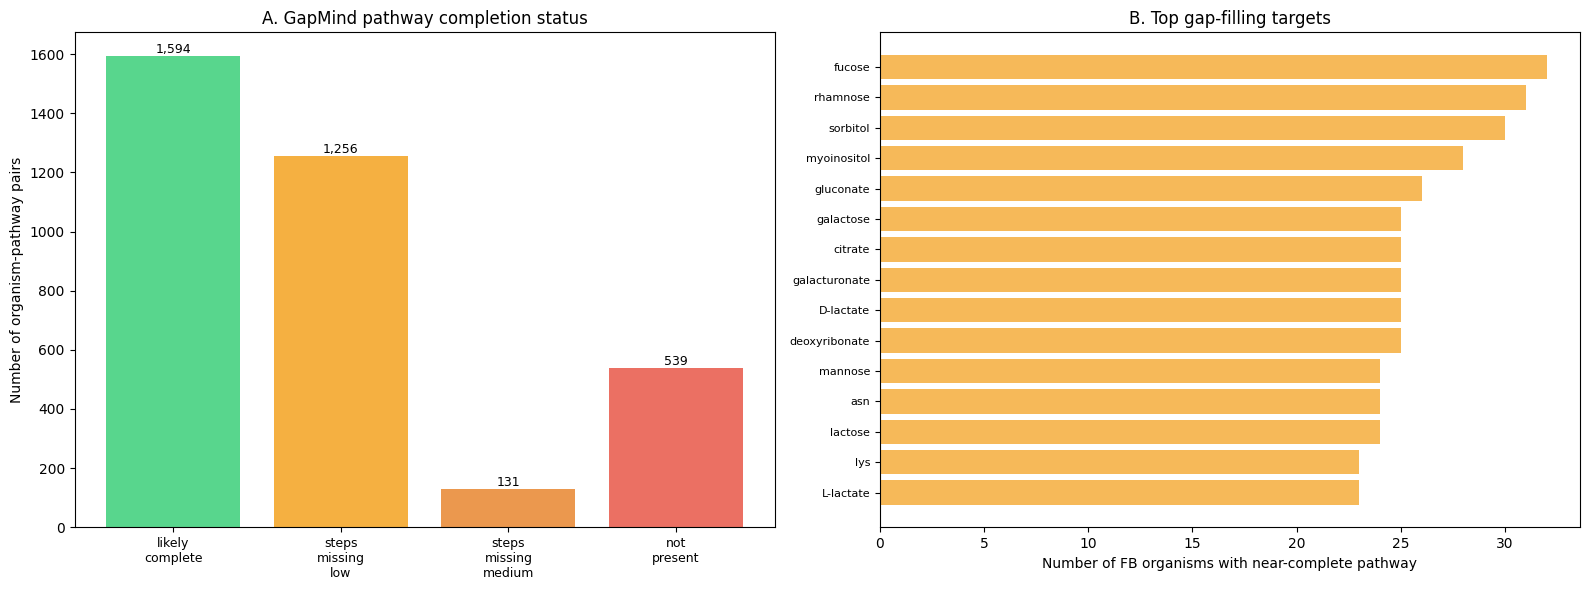

In [18]:
# Figure 5: GapMind pathway completion landscape
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Pathway completion status across organisms
status_counts = gapmind_species.groupby('best_score_category')['orgId'].count()
status_order = ['likely_complete', 'steps_missing_low', 'steps_missing_medium', 'not_present']
status_colors = {'likely_complete': '#2ecc71', 'steps_missing_low': '#f39c12', 
                 'steps_missing_medium': '#e67e22', 'not_present': '#e74c3c'}
status_vals = [status_counts.get(s, 0) for s in status_order]

axes[0].bar(range(len(status_order)), status_vals, 
            color=[status_colors[s] for s in status_order], alpha=0.8)
axes[0].set_xticks(range(len(status_order)))
axes[0].set_xticklabels([s.replace('_', '\n') for s in status_order], fontsize=9)
axes[0].set_ylabel('Number of organism-pathway pairs')
axes[0].set_title('A. GapMind pathway completion status')
for i, v in enumerate(status_vals):
    axes[0].text(i, v + 10, f'{v:,}', ha='center', fontsize=9)

# Panel B: Top near-complete pathways
top_gaps = gap_df.groupby('pathway').agg(
    n_orgs=('orgId', 'nunique'),
    total_dark_strong=('n_dark_strong_fitness', 'sum')
).sort_values('n_orgs', ascending=True).tail(15)

axes[1].barh(range(len(top_gaps)), top_gaps['n_orgs'].values, color='#f39c12', alpha=0.7)
axes[1].set_yticks(range(len(top_gaps)))
axes[1].set_yticklabels(top_gaps.index, fontsize=8)
axes[1].set_xlabel('Number of FB organisms with near-complete pathway')
axes[1].set_title('B. Top gap-filling targets')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig05_gapmind_gaps.png'), dpi=150, bbox_inches='tight')
plt.show()

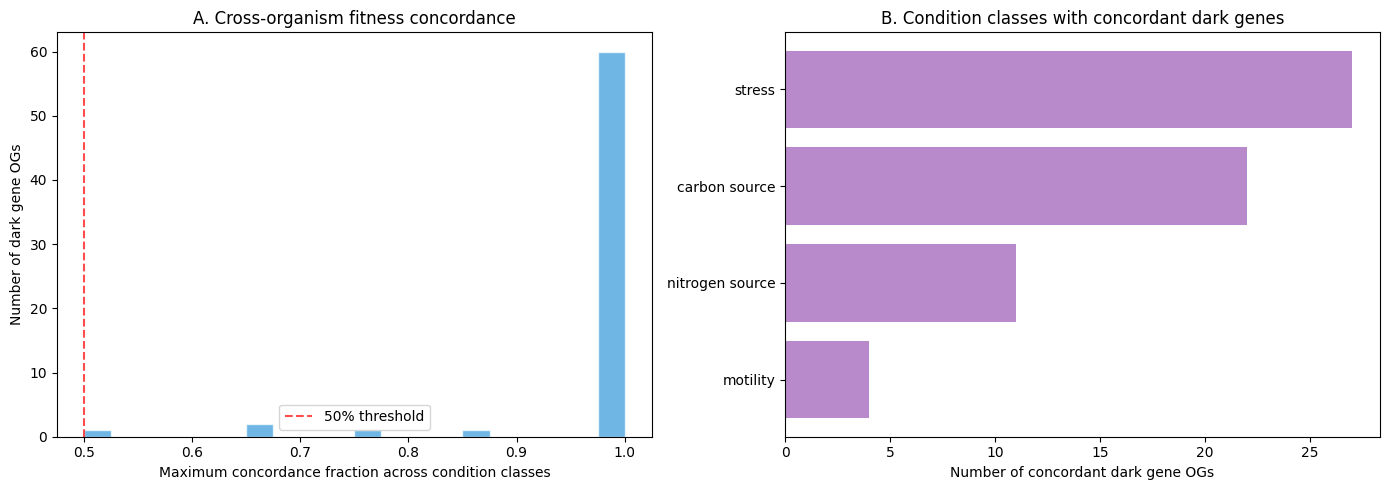

In [19]:
# Figure 6: Cross-organism concordance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Distribution of max concordance per OG
axes[0].hist(og_concordance['max_concordance'], bins=20, color='#3498db', alpha=0.7, edgecolor='white')
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='50% threshold')
axes[0].set_xlabel('Maximum concordance fraction across condition classes')
axes[0].set_ylabel('Number of dark gene OGs')
axes[0].set_title('A. Cross-organism fitness concordance')
axes[0].legend()

# Panel B: Top condition classes for concordant OGs
concordant_conditions = high_concordance.groupby('expGroup')['ogId'].nunique().sort_values(ascending=True)
if len(concordant_conditions) > 0:
    axes[1].barh(range(len(concordant_conditions)), concordant_conditions.values, 
                 color='#9b59b6', alpha=0.7)
    axes[1].set_yticks(range(len(concordant_conditions)))
    axes[1].set_yticklabels(concordant_conditions.index)
    axes[1].set_xlabel('Number of concordant dark gene OGs')
    axes[1].set_title('B. Condition classes with concordant dark genes')
else:
    axes[1].text(0.5, 0.5, 'No high concordance found', ha='center', va='center')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig06_concordance.png'), dpi=150, bbox_inches='tight')
plt.show()

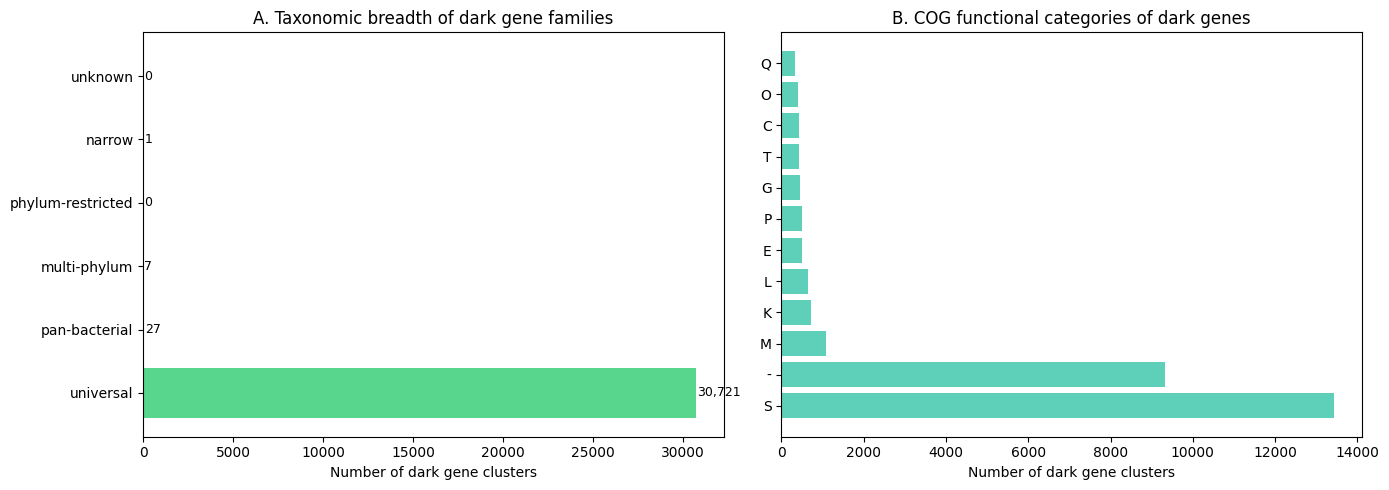

In [20]:
# Figure 7: Phylogenetic breadth of dark gene families
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Breadth class distribution
breadth_order = ['universal', 'pan-bacterial', 'multi-phylum', 'phylum-restricted', 'narrow', 'unknown']
breadth_colors = {'universal': '#2ecc71', 'pan-bacterial': '#3498db', 'multi-phylum': '#9b59b6',
                  'phylum-restricted': '#e67e22', 'narrow': '#e74c3c', 'unknown': '#95a5a6'}
breadth_counts = phylo_breadth['breadth_class'].value_counts().reindex(breadth_order).fillna(0)

axes[0].barh(range(len(breadth_counts)), breadth_counts.values,
             color=[breadth_colors.get(b, '#95a5a6') for b in breadth_counts.index], alpha=0.8)
axes[0].set_yticks(range(len(breadth_counts)))
axes[0].set_yticklabels(breadth_counts.index)
axes[0].set_xlabel('Number of dark gene clusters')
axes[0].set_title('A. Taxonomic breadth of dark gene families')
for i, v in enumerate(breadth_counts.values):
    axes[0].text(v + 50, i, f'{int(v):,}', va='center', fontsize=9)

# Panel B: COG category distribution
cog_cats = phylo_breadth['COG_category'].fillna('None').value_counts().head(12)
axes[1].barh(range(len(cog_cats)), cog_cats.values, color='#1abc9c', alpha=0.7)
axes[1].set_yticks(range(len(cog_cats)))
axes[1].set_yticklabels(cog_cats.index)
axes[1].set_xlabel('Number of dark gene clusters')
axes[1].set_title('B. COG functional categories of dark genes')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig07_phylo_breadth.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Outputs

In [21]:
# Save GapMind gap candidates
gap_df.to_csv(os.path.join(DATA_DIR, 'gapmind_gap_candidates.tsv'), sep='\t', index=False)
print(f"Saved: gapmind_gap_candidates.tsv ({len(gap_df)} entries)")

# Save pathway summary
pathway_summary.to_csv(os.path.join(DATA_DIR, 'gapmind_pathway_summary.tsv'), sep='\t', index=False)
print(f"Saved: gapmind_pathway_summary.tsv ({len(pathway_summary)} pathways)")

# Save concordance scores
og_concordance.to_csv(os.path.join(DATA_DIR, 'concordance_scores.tsv'), sep='\t', index=False)
print(f"Saved: concordance_scores.tsv ({len(og_concordance)} OGs)")

# Save detailed concordance per OG x condition
concordance.to_csv(os.path.join(DATA_DIR, 'concordance_detailed.tsv'), sep='\t', index=False)
print(f"Saved: concordance_detailed.tsv ({len(concordance)} entries)")

# Save phylogenetic breadth
phylo_breadth.to_csv(os.path.join(DATA_DIR, 'phylogenetic_breadth.tsv'), sep='\t', index=False)
print(f"Saved: phylogenetic_breadth.tsv ({len(phylo_breadth)} clusters)")

Saved: gapmind_gap_candidates.tsv (1256 entries)
Saved: gapmind_pathway_summary.tsv (80 pathways)
Saved: concordance_scores.tsv (65 OGs)
Saved: concordance_detailed.tsv (65 entries)
Saved: phylogenetic_breadth.tsv (30756 clusters)


## 6. Summary

In [22]:
print("=" * 70)
print("NB02 SUMMARY: GapMind Gaps, Concordance & Phylogenetic Distribution")
print("=" * 70)

print(f"\n--- GapMind Gap-Filling ---")
print(f"Species-pathway entries queried:  {len(gapmind_species):>10,}")
print(f"Near-complete pathways:           {len(near_complete):>10,}")
n_nc_orgs = near_complete['orgId'].nunique() if len(near_complete) > 0 else 0
n_nc_pathways = near_complete['pathway'].nunique() if len(near_complete) > 0 else 0
print(f"  Across organisms:              {n_nc_orgs:>10,}")
print(f"  Unique pathways:               {n_nc_pathways:>10,}")

print(f"\n--- Cross-Organism Concordance ---")
print(f"Dark gene OGs tested (3+ orgs):  {len(og_concordance):>10,}")
if len(og_concordance) > 0:
    print(f"OGs with high concordance (>50%):{(og_concordance['max_concordance'] > 0.5).sum():>10,}")
    print(f"OGs with very high conc (>75%):  {(og_concordance['max_concordance'] > 0.75).sum():>10,}")
    n_conc_conditions = high_concordance['expGroup'].nunique() if len(high_concordance) > 0 else 0
    print(f"Condition classes with concordance:{n_conc_conditions:>8,}")
else:
    print("  (No concordance data)")

print(f"\n--- Phylogenetic Distribution ---")
print(f"Dark clusters with eggNOG:       {len(eggnog):>10,}")
for bc in ['universal', 'pan-bacterial', 'multi-phylum', 'phylum-restricted', 'narrow']:
    n = (phylo_breadth['breadth_class'] == bc).sum()
    pct = 100 * n / len(phylo_breadth) if len(phylo_breadth) > 0 else 0
    print(f"  {bc:25s}: {n:>8,} ({pct:.1f}%)")
print(f"Unique root OGs:                 {eggnog['root_og'].nunique():>10,}")
print(f"With EC numbers:                 {has_value(eggnog['EC']).sum():>10,}")
print(f"With KEGG KO:                    {has_value(eggnog['KEGG_ko']).sum():>10,}")
print(f"With PFAMs:                      {has_value(eggnog['PFAMs']).sum():>10,}")

print("\n" + "=" * 70)

NB02 SUMMARY: GapMind Gaps, Concordance & Phylogenetic Distribution

--- GapMind Gap-Filling ---
Species-pathway entries queried:       3,520
Near-complete pathways:                1,256
  Across organisms:                      44
  Unique pathways:                       78

--- Cross-Organism Concordance ---
Dark gene OGs tested (3+ orgs):          65
OGs with high concordance (>50%):        64
OGs with very high conc (>75%):          61
Condition classes with concordance:       4

--- Phylogenetic Distribution ---
Dark clusters with eggNOG:           30,756
  universal                :   30,721 (99.9%)
  pan-bacterial            :       27 (0.1%)
  multi-phylum             :        7 (0.0%)
  phylum-restricted        :        0 (0.0%)
  narrow                   :        1 (0.0%)
Unique root OGs:                     11,774
With EC numbers:                      1,120
With KEGG KO:                         5,951
With PFAMs:                          19,783

